In [39]:
import numpy as np

from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.preprocessing import minmax_scale

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.utils import check_random_state

plt.rcParams['image.cmap'] = 'gray'

In [40]:
from emnist import list_datasets
from emnist import extract_training_samples
X_train, Y_train = extract_training_samples('mnist')

In [41]:
from emnist import extract_test_samples
X_test, Y_test = extract_test_samples('mnist')

In [42]:
X_train=X_train.reshape(60000, 784)
X_test=X_test.reshape(10000, 784)


X_train = minmax_scale(X_train, feature_range=(0, 1))  # 0-1 scaling
X_test = minmax_scale(X_test, feature_range=(0, 1))  # 0-1 scaling

In [43]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

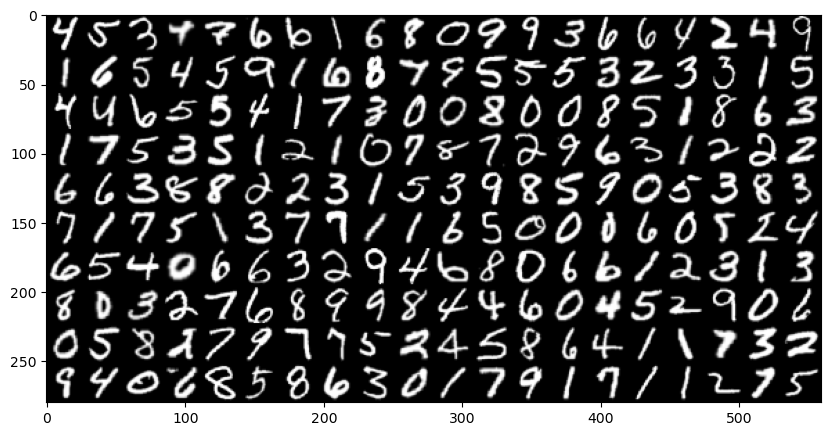

In [44]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train))

## Models definition

In [45]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(random_state=0, verbose=True)

In [46]:
from sklearn.base import clone

rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 5

Fit RBM

In [47]:
# Training RBM and obtaining the transformed input for Logistic
rbm=rbm.fit(X_train)
Q_train=rbm.transform(X_train)
Q_test=rbm.transform(X_test)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -214.51, time = 15.58s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -209.41, time = 7.72s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -206.46, time = 10.62s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -206.93, time = 15.19s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -204.88, time = 13.76s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -207.11, time = 11.67s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -210.07, time = 13.91s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -206.14, time = 9.37s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -204.21, time = 15.62s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -207.33, time = 6.96s


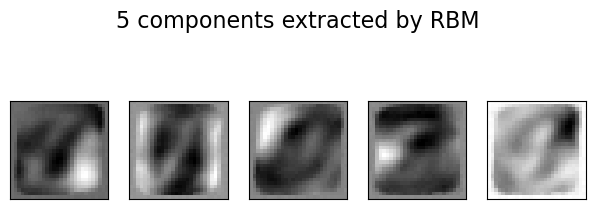

In [48]:
## Plotting
plt.figure(figsize=(7, 7))
for i, comp in enumerate(rbm.components_):
    plt.subplot(5, 5, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("5 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

## Generation and reconstruction

In [49]:
from scipy.special import expit
def our_sample_visible(h, rng):
    p = np.dot(h, rbm.components_)
    p += rbm.intercept_visible_
    expit(p, out=p)
    return (p, rng.uniform(size=p.shape) < p)

In [50]:
def our_gibbs(v):
    if not hasattr(rbm, "random_state_"):
        rbm.random_state_ = check_random_state(rbm.random_state)
    h_ = rbm._sample_hiddens(v, rbm.random_state_)
    p, v_ = our_sample_visible(h_, rbm.random_state_)
    return (p, v_)

**Generation**: try to generate 10 new images starting from an image of 28x28 random binomial pixels

In [51]:
xx = X_train[:10].copy()
p = X_train[:10].copy()
for n in range(10):
    xx[n]= np.random.binomial(1,0.5, size=784)

In [52]:
for ii in range(10000):
    for i in range(10):
        p[i], xx[i] = our_gibbs(xx[i])

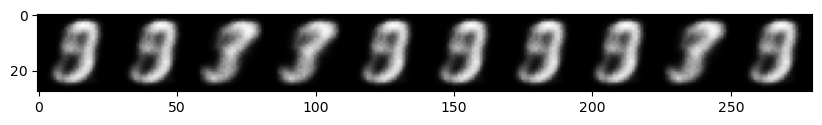

In [53]:
def gen_mnist_image20(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(10, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 10 * 28)
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image20(p))

Now let's try to see the reconstruction error for each digit in the dataset

First, separate different digits in different vectors

In [54]:
digit0 = []
digit1 = []
digit2 = []
digit3 = []
digit4 = []
digit5 = []
digit6 = []
digit7 = []
digit8 = []
digit9 = []

In [55]:
for i in range(Y_test.shape[0]):
    if Y_test[i] == 0:
        digit0.append(X_test[i])
    if Y_test[i] == 1:
        digit1.append(X_test[i]) 
    if Y_test[i] == 2:
        digit2.append(X_test[i]) 
    if Y_test[i] == 3:
        digit3.append(X_test[i]) 
    if Y_test[i] == 4:
        digit4.append(X_test[i]) 
    if Y_test[i] == 5:
        digit5.append(X_test[i]) 
    if Y_test[i] == 6:
        digit6.append(X_test[i]) 
    if Y_test[i] == 7:
        digit7.append(X_test[i]) 
    if Y_test[i] == 8:
        digit8.append(X_test[i]) 
    if Y_test[i] == 9:
        digit9.append(X_test[i])

In [56]:
digits = np.array((np.array(digit0), np.array(digit1), np.array(digit2), np.array(digit3),np.array(digit4),np.array(digit5),
np.array(digit6),np.array(digit7),np.array(digit8),np.array(digit9)))
print(digits.shape)

(10, 1000, 784)


In [57]:
reconstructed_imgs = np.zeros((10,1000,784))
reconstruction_err = np.zeros((10,1000))
mean_err = np.zeros(10)
std_err = np.zeros(10)
for j in range(10):
    curr_digit = digits[j]
    for i in range(1000):
        reconstructed_imgs[j][i], _ = our_gibbs(curr_digit[i])
        reconstruction_err[j][i] = np.sum(np.abs(reconstructed_imgs[j][i] - curr_digit[i])**2)/784
    mean_err[j] = np.sum(reconstruction_err[j])/1000
    std_err[j] = np.std(reconstruction_err[j])
    print("Mean square error for digit ", j, ": ",mean_err[j], "| Standard deviation for digit ", j, ": ",std_err[j])

Mean square error for digit  0 :  0.06836889058980244 | Standard deviation for digit  0 :  0.01705121412149837
Mean square error for digit  1 :  0.038743570325148795 | Standard deviation for digit  1 :  0.012855292851857407
Mean square error for digit  2 :  0.07748153362031499 | Standard deviation for digit  2 :  0.015064184460608655
Mean square error for digit  3 :  0.06253596091687728 | Standard deviation for digit  3 :  0.016415595342696265
Mean square error for digit  4 :  0.06925267714764838 | Standard deviation for digit  4 :  0.01708647217654124
Mean square error for digit  5 :  0.07213628968126434 | Standard deviation for digit  5 :  0.015565521980734593
Mean square error for digit  6 :  0.0609578110683602 | Standard deviation for digit  6 :  0.01521212826113039
Mean square error for digit  7 :  0.0566010185711211 | Standard deviation for digit  7 :  0.018304993524299568
Mean square error for digit  8 :  0.06939993111273092 | Standard deviation for digit  8 :  0.017845193981910

In [58]:
print("The mean of the reconstruction error on all the images is:", np.mean(mean_err))

The mean of the reconstruction error on all the images is: 0.06312607489430981


<Figure size 640x480 with 0 Axes>

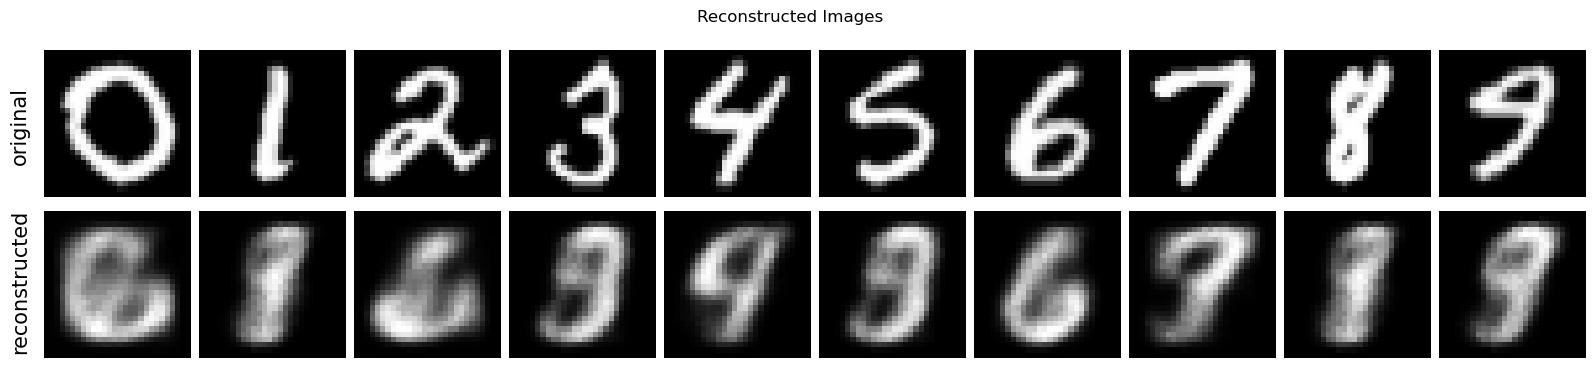

In [59]:
images2 = np.array([digit0[0],digit1[0],digit2[0],digit3[0],digit4[0],digit5[0],digit6[0],digit7[0],digit8[0],digit9[0]])
num_samples = len(images2)
title='Reconstructed Images'
plt.clf()
fig, axes = plt.subplots(2, num_samples, gridspec_kw = {'wspace':0, 'hspace':0.1}, figsize=(num_samples*2, 4))
fig.suptitle(title)
text = axes[0, 0].text(-7, 14,"original", size=15, verticalalignment='center', rotation=-270)
text = axes[1, 0].text(-7, 13,"reconstructed", size=15, verticalalignment='center', rotation=-270)
for n in range(num_samples):
    axes[0, n].imshow(images2[n].reshape(28, 28), cmap='gray')
    axes[1, n].imshow(reconstructed_imgs[n][0].reshape(28, 28), cmap='gray')
    #axes[1, n].imshow(images2[n+10].reshape(28, 28), cmap='gray')
    axes[0, n].axis('off')
    axes[1, n].axis('off')

plt.show()
plt.close()